<a href="https://colab.research.google.com/github/kuanjulin/vllm-benchmarks/blob/main/vllm_benchmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Jun 25 07:05:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
### Installation
!pip install vllm transformers accelerate
!pip install --upgrade datasets

In [ ]:
try:
    from vllm import LLM, SamplingParams
    print("vLLM import successful")
except ImportError as e:
    print("Import failed:", e)

INFO 06-25 07:12:12 [__init__.py:244] Automatically detected platform cuda.
vLLM import successful


In [ ]:
# Restart runtime
import os

os.kill(os.getpid(), 9)

In [ ]:
from vllm import LLM, SamplingParams
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer

import time
import torch
import re

gsm8k = load_dataset("gsm8k", "main", split="test")

def extract_answer(text):
    match = re.search(r"The answer is (\d+)", text)
    return int(match.group(1)) if match else None

def benchmark_gsm8k_vllm(model_id, dtype=None, quant=None, name="", dataset=None):
    print(f"Loading {name or model_id} with vLLM...")
    start_time = time.time()
    llm = LLM(model=model_id, dtype=dtype, quantization=quant)
    load_time = time.time() - start_time
    print(f"Model loaded in {load_time:.2f} seconds")

    prompts = [item["question"] for item in dataset]
    expected_answers = [extract_answer(item["answer"]) for item in dataset]

    sampling_params = SamplingParams(temperature=0.7, top_p=0.9, max_tokens=128)

    print("Running inference with vLLM...")
    start = time.time()
    outputs = llm.generate(prompts, sampling_params)
    duration = time.time() - start

    tokens = sum(len(o.outputs[0].token_ids) for o in outputs)
    print(f"{name}: {tokens} tokens generated in {duration:.2f}s")
    print(f"Tokens/sec: {tokens / duration:.2f}")

    correct = 0
    for i, output in enumerate(outputs):
        pred = extract_answer(output.outputs[0].text.strip())
        gold = expected_answers[i]
        if pred == gold:
            correct += 1

    accuracy = correct / len(outputs)

    del llm
    torch.cuda.empty_cache()

    return {
        "name": name or model_id,
        "tokens": tokens,
        "time": duration,
        "tokens_per_sec": tokens / duration,
        "load_time": load_time,
        "accuracy": accuracy,
    }

def benchmark_gsm8k_hf(model_id, dtype=None, name="", dataset=None):
    print(f"Loading {name or model_id} with Hugging Face transformers...")
    start_time = time.time()
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    torch_dtype = torch.float16 if dtype == "float16" else torch.float32
    model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch_dtype).to("cuda")
    load_time = time.time() - start_time
    print(f"Model loaded in {load_time:.2f} seconds")

    prompts = [item["question"] for item in dataset]
    expected_answers = [extract_answer(item["answer"]) for item in dataset]

    tokens = 0
    correct = 0
    total = len(prompts)

    print("Running inference with Hugging Face transformers...")
    start = time.time()
    for i, prompt in enumerate(prompts):
        inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
        with torch.no_grad():
            outputs_ids = model.generate(**inputs, max_new_tokens=128)
        generated_text = tokenizer.decode(outputs_ids[0], skip_special_tokens=True)
        tokens += len(outputs_ids[0])

        pred = extract_answer(generated_text.strip())
        gold = expected_answers[i]
        if pred == gold:
            correct += 1

    duration = time.time() - start
    accuracy = correct / total

    print(f"{name}: {tokens} tokens generated in {duration:.2f}s")
    print(f"Tokens/sec: {tokens / duration:.2f}")

    del model
    torch.cuda.empty_cache()

    return {
        "name": name or model_id,
        "tokens": tokens,
        "time": duration,
        "tokens_per_sec": tokens / duration,
        "load_time": load_time,
        "accuracy": accuracy,
    }

INFO 06-25 07:34:20 [__init__.py:244] Automatically detected platform cuda.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
subset = load_dataset("gsm8k", "main", split="test")

results = []
results.append(benchmark_gsm8k_vllm("TinyLlama/TinyLlama-1.1B-Chat-v1.0", dtype="float32", name="FP32", dataset=subset))
print(results)

Loading FP32 with vLLM...
INFO 06-25 07:41:19 [config.py:823] This model supports multiple tasks: {'score', 'embed', 'classify', 'reward', 'generate'}. Defaulting to 'generate'.
INFO 06-25 07:41:19 [config.py:3265] Upcasting torch.bfloat16 to torch.float32.
WARNING 06-25 07:41:19 [arg_utils.py:1642] Compute Capability < 8.0 is not supported by the V1 Engine. Falling back to V0. 
INFO 06-25 07:41:19 [llm_engine.py:230] Initializing a V0 LLM engine (v0.9.1) with config: model='TinyLlama/TinyLlama-1.1B-Chat-v1.0', speculative_config=None, tokenizer='TinyLlama/TinyLlama-1.1B-Chat-v1.0', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float32, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=De

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 06-25 07:41:27 [default_loader.py:272] Loading weights took 4.72 seconds
INFO 06-25 07:41:28 [model_runner.py:1203] Model loading took 4.0986 GiB and 5.227067 seconds
INFO 06-25 07:41:29 [worker.py:294] Memory profiling takes 1.52 seconds
INFO 06-25 07:41:29 [worker.py:294] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.90) = 13.27GiB
INFO 06-25 07:41:29 [worker.py:294] model weights take 4.10GiB; non_torch_memory takes 0.02GiB; PyTorch activation peak memory takes 0.29GiB; the rest of the memory reserved for KV Cache is 8.86GiB.
INFO 06-25 07:41:30 [executor_base.py:113] # cuda blocks: 13194, # CPU blocks: 5957
INFO 06-25 07:41:30 [executor_base.py:118] Maximum concurrency for 2048 tokens per request: 103.08x
INFO 06-25 07:41:33 [model_runner.py:1513] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in 

Capturing CUDA graph shapes:   0%|          | 0/35 [00:00<?, ?it/s]

INFO 06-25 07:42:08 [model_runner.py:1671] Graph capturing finished in 34 secs, took 0.15 GiB
INFO 06-25 07:42:08 [llm_engine.py:428] init engine (profile, create kv cache, warmup model) took 40.01 seconds
Model loaded in 71.31 seconds
Running inference with vLLM...


Adding requests:   0%|          | 0/1319 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1319 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

FP32: 31750 tokens generated in 86.88s
Tokens/sec: 365.46
[{'name': 'FP32', 'tokens': 31750, 'time': 86.87782192230225, 'tokens_per_sec': 365.4557549612039, 'load_time': 71.31380915641785, 'accuracy': 0.9969673995451099}]


In [ ]:
subset = load_dataset("gsm8k", "main", split="test")

results = []
results.append(benchmark_gsm8k_hf("TinyLlama/TinyLlama-1.1B-Chat-v1.0", dtype="float32", name="HF Transformers FP32", dataset=subset))
print(results)

Loading HF Transformers FP32 with Hugging Face transformers...
Model loaded in 14.06 seconds
Running inference with Hugging Face transformers...
HF Transformers FP32: 99917 tokens generated in 318.01s
Tokens/sec: 314.20
[{'name': 'HF Transformers FP32', 'tokens': 99917, 'time': 318.0070593357086, 'tokens_per_sec': 314.1974275939617, 'load_time': 14.063783407211304, 'accuracy': 0.9992418498862775}]


In [ ]:
subset = load_dataset("gsm8k", "main", split="test")

results = []
results.append(benchmark_gsm8k_vllm("TinyLlama/TinyLlama-1.1B-Chat-v1.0", dtype="float16", name="FP16", dataset=subset))
print(results)

Loading FP16 with vLLM...
INFO 06-25 07:29:29 [config.py:823] This model supports multiple tasks: {'classify', 'embed', 'generate', 'score', 'reward'}. Defaulting to 'generate'.
WARNING 06-25 07:29:29 [config.py:3271] Casting torch.bfloat16 to torch.float16.
WARNING 06-25 07:29:29 [arg_utils.py:1642] Compute Capability < 8.0 is not supported by the V1 Engine. Falling back to V0. 
INFO 06-25 07:29:29 [llm_engine.py:230] Initializing a V0 LLM engine (v0.9.1) with config: model='TinyLlama/TinyLlama-1.1B-Chat-v1.0', speculative_config=None, tokenizer='TinyLlama/TinyLlama-1.1B-Chat-v1.0', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=D

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 06-25 07:29:34 [default_loader.py:272] Loading weights took 2.02 seconds
INFO 06-25 07:29:35 [model_runner.py:1203] Model loading took 2.0513 GiB and 2.477739 seconds
INFO 06-25 07:29:36 [worker.py:294] Memory profiling takes 0.77 seconds
INFO 06-25 07:29:36 [worker.py:294] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.90) = 13.27GiB
INFO 06-25 07:29:36 [worker.py:294] model weights take 2.05GiB; non_torch_memory takes 0.02GiB; PyTorch activation peak memory takes 0.30GiB; the rest of the memory reserved for KV Cache is 10.90GiB.
INFO 06-25 07:29:36 [executor_base.py:113] # cuda blocks: 32457, # CPU blocks: 11915
INFO 06-25 07:29:36 [executor_base.py:118] Maximum concurrency for 2048 tokens per request: 253.57x
INFO 06-25 07:29:41 [model_runner.py:1513] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' i

Capturing CUDA graph shapes:   0%|          | 0/35 [00:00<?, ?it/s]

INFO 06-25 07:30:58 [model_runner.py:1671] Graph capturing finished in 76 secs, took 0.13 GiB
INFO 06-25 07:30:58 [llm_engine.py:428] init engine (profile, create kv cache, warmup model) took 83.13 seconds
Model loaded in 110.62 seconds
Running inference with vLLM...


Adding requests:   0%|          | 0/1319 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1319 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s…

FP16: 30924 tokens generated in 27.88s
Tokens/sec: 1109.08
[{'name': 'FP16', 'tokens': 30924, 'time': 27.882638692855835, 'tokens_per_sec': 1109.077241241283, 'load_time': 110.61513686180115, 'accuracy': 0.9969673995451099}]


In [ ]:
subset = load_dataset("gsm8k", "main", split="test")

results = []
results.append(benchmark_gsm8k_hf("TinyLlama/TinyLlama-1.1B-Chat-v1.0", dtype="float16", name="HF Transformers FP16", dataset=subset))
print(results)

Loading HF Transformers FP16 with Hugging Face transformers...
Model loaded in 6.43 seconds
Running inference with Hugging Face transformers...
HF Transformers FP16: 99778 tokens generated in 259.24s
Tokens/sec: 384.89
[{'name': 'HF Transformers FP16', 'tokens': 99778, 'time': 259.2394299507141, 'tokens_per_sec': 384.8874379139374, 'load_time': 6.430678606033325, 'accuracy': 0.9992418498862775}]


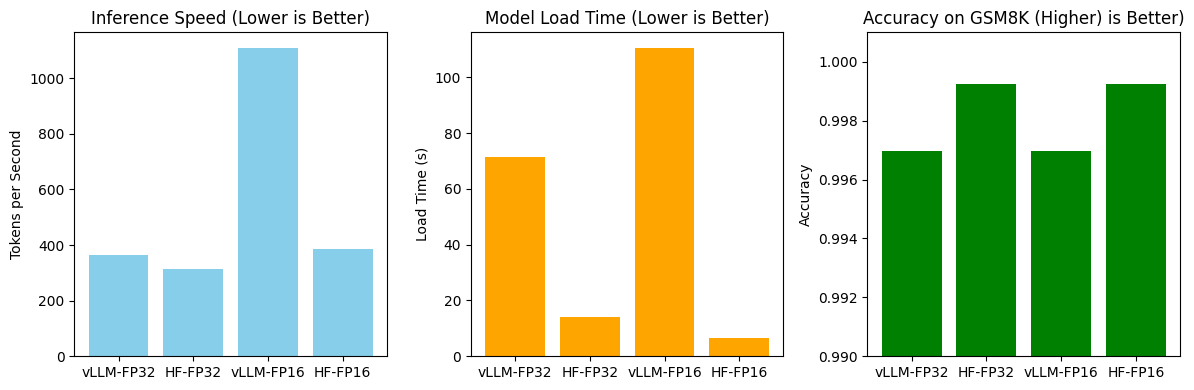

In [ ]:
import matplotlib.pyplot as plt

# All benchmark results
results = [
    {'name': 'vLLM-FP32', 'tokens': 31750, 'time': 86.87782192230225, 'tokens_per_sec': 365.4557549612039, 'load_time': 71.31380915641785, 'accuracy': 0.9969673995451099},
    {'name': 'HF-FP32', 'tokens': 99917, 'time': 318.0070593357086, 'tokens_per_sec': 314.1974275939617, 'load_time': 14.063783407211304, 'accuracy': 0.9992418498862775},
    {'name': 'vLLM-FP16', 'tokens': 30924, 'time': 27.882638692855835, 'tokens_per_sec': 1109.077241241283, 'load_time': 110.61513686180115, 'accuracy': 0.9969673995451099},
    {'name': 'HF-FP16', 'tokens': 99778, 'time': 259.2394299507141, 'tokens_per_sec': 384.8874379139374, 'load_time': 6.430678606033325, 'accuracy': 0.9992418498862775}
]

# Extract values for plotting
names = [r['name'] for r in results]
tokens_per_sec = [r['tokens_per_sec'] for r in results]
load_times = [r['load_time'] for r in results]
accuracies = [r['accuracy'] for r in results]

# Plot Tokens/sec
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.bar(names, tokens_per_sec, color='skyblue')
plt.ylabel('Tokens per Second')
plt.title('Inference Speed (Lower is Better)')

# Plot Load Time
plt.subplot(1, 3, 2)
plt.bar(names, load_times, color='orange')
plt.ylabel('Load Time (s)')
plt.title('Model Load Time (Lower is Better)')

# Plot Accuracy
plt.subplot(1, 3, 3)
plt.bar(names, accuracies, color='green')
plt.ylim(0.99, 1.001)
plt.ylabel('Accuracy')
plt.title('Accuracy on GSM8K (Higher) is Better)')

plt.tight_layout()
plt.show()